# Pathway enrichment in MAFA WT T0
Collab Theis - Hebrok labs

Data analysis: Alexander Fastner

based on Data analysis by: Sara Jimenez

Data generation: Veronica Cochrane

## Loading Packages

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd
from anndata import AnnData

## Load Data

In [2]:
# Read raw data and process it
adata = pd.read_csv('../data/MAFA_WT_gene_count.txt', index_col=20, sep='\t').T
adata

gene_name,CHGA,MT-CO1,GCG,INS,MT-ND4,EEF1A1,MT-ND5,TTR,MT-CO2,MT-CYB,...,RNA5-8SN4,AL354822.1,AC023491.2,RF00003,RF01972,RF01973,RF01974,AC233755.2,AC233755.1,AC213203.1
MAFAWT_001,769950,469036,398234,164748,186078,116719,151341,178909,133640,121061,...,0,0,0,0,0,0,0,0,0,0
MAFAWT_002,760265,204988,207026,146662,80616,98010,70795,109150,55131,49581,...,0,0,0,0,0,0,0,0,0,0
MAFAWT_003,672585,522418,378290,146501,243656,93180,195788,131732,163870,158054,...,0,0,0,0,0,0,0,0,0,0
MAFAWT_004,820162,262856,502891,171062,117809,132909,97752,150350,79653,75222,...,0,0,0,0,0,0,0,0,0,0
MAFAWT_005,878886,335731,73413,123677,122960,127821,102340,30019,96654,85530,...,0,0,0,0,0,0,0,0,0,0
MAFAWT_006,878745,350758,114376,147449,134333,125976,105483,31916,99623,94874,...,0,0,0,0,0,0,0,0,0,0
MAFAWT_007,1129979,359712,159369,65313,156749,104854,156351,25998,108889,113709,...,0,0,0,0,0,0,0,0,0,0
MAFAWT_008,1017468,285966,157747,109003,111200,119484,89777,32111,89609,81167,...,0,0,0,0,0,0,0,0,0,0
MAFAWT_009,800671,176313,194431,139982,64275,101077,52585,53031,49169,39752,...,0,0,0,0,0,0,0,0,0,0
MAFAWT_010,633710,177343,219577,113536,73264,76057,64194,57478,50504,46106,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Transform to AnnData object
adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()
adata

/root/anaconda3/envs/decoupler/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/root/anaconda3/envs/decoupler/lib/python3.9/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 20 × 58735

In [4]:
# Read metadata 
metadata = pd.read_csv('../data/2023_MAFA_MetaData.txt', index_col=0, sep='\t')
metadata

,Sample_Description,Treatment,Genotype,TimePoint,Batch,DOX,GroupName
SampleID,,,,,,,
MAFAWT_001,MAFAWT,MAFA,WT,T0,1,N,MAFA_WT_T0
MAFAWT_002,MAFAWT,MAFA,WT,T0,1,N,MAFA_WT_T0
MAFAWT_003,MAFAWT,MAFA,WT,T0,1,N,MAFA_WT_T0
MAFAWT_004,MAFAWT,MAFA,WT,T0,1,N,MAFA_WT_T0
MAFAWT_005,MAFAWT,MAFA,WT,T2,1,Y,MAFA_WT_T2
MAFAWT_006,MAFAWT,MAFA,WT,T2,1,Y,MAFA_WT_T2
MAFAWT_007,MAFAWT,MAFA,WT,T2,1,Y,MAFA_WT_T2
MAFAWT_008,MAFAWT,MAFA,WT,T2,1,Y,MAFA_WT_T2
MAFAWT_009,MAFAWT,MAFA,WT,T1,1,Y,MAFA_WT_T1


In [5]:
adata.obs['condition'] = metadata['Treatment']
adata.obs['time_point'] = metadata['TimePoint']
adata.obs['DOX'] = metadata['DOX']
adata.obs

,condition,time_point,DOX
MAFAWT_001,MAFA,T0,N
MAFAWT_002,MAFA,T0,N
MAFAWT_003,MAFA,T0,N
MAFAWT_004,MAFA,T0,N
MAFAWT_005,MAFA,T2,Y
MAFAWT_006,MAFA,T2,Y
MAFAWT_007,MAFA,T2,Y
MAFAWT_008,MAFA,T2,Y
MAFAWT_009,MAFA,T1,Y
MAFAWT_010,MAFA,T1,Y


In [6]:
# split data set by timepoint
subset_t0 = adata[adata.obs.time_point == 'T0']
print("Subset for time point T0:")
print(subset_t0)
subset_t0.obs
# print("\nSubset for time point T1:")
# print(subset_t1)
# print("\nSubset for time point T2:")
# print(subset_t2)

Subset for time point T0:
View of AnnData object with n_obs × n_vars = 7 × 58735
    obs: 'condition', 'time_point', 'DOX'


,condition,time_point,DOX
MAFAWT_001,MAFA,T0,N
MAFAWT_002,MAFA,T0,N
MAFAWT_003,MAFA,T0,N
MAFAWT_004,MAFA,T0,N
MAFAWT_012,Control,T0,N
MAFAWT_013,Control,T0,N
MAFAWT_014,Control,T0,N


## Quality Control

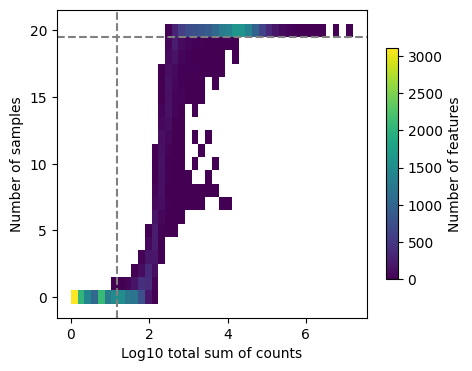

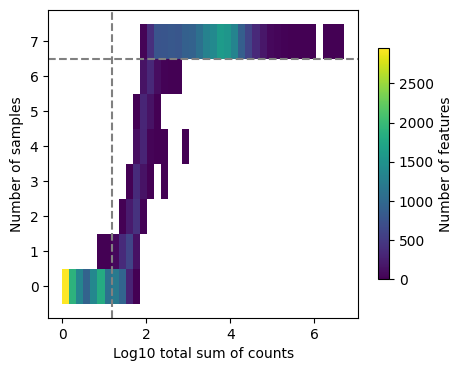

In [7]:
#check various filter points
#old
dc.plot_filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)
dc.plot_filter_by_expr(subset_t0, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1,save='../figures/WT/t0_QC.png')


In [8]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(subset_t0, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)
genes.size

15760

In [9]:
# Filter by these genes
adata = subset_t0[:, genes].copy()
adata

AnnData object with n_obs × n_vars = 7 × 15760
    obs: 'condition', 'time_point', 'DOX'

In [10]:
#!pip install pydeseq2

In [11]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [12]:
adata.X = np.round(adata.X,0)

In [13]:
# Build DESeq2 object
dds = DeseqDataSet(
    adata=adata,
    design_factors='condition',
    refit_cooks=True,
    n_cpus=8,
)

In [14]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 19.89 seconds.

Fitting dispersion trend curve...
... done in 3.70 seconds.

Fitting MAP dispersions...
... done in 20.30 seconds.

Fitting LFCs...
... done in 1.69 seconds.

Refitting 0 outliers.



In [15]:
# Extract contrast 
stat_res = DeseqStats(dds, contrast=["condition", 'MAFA', 'Control'], n_cpus=8)

In [16]:
# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition MAFA vs Control


... done in 0.97 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_name,,,,,,
CHGA,720814.562500,0.080810,0.093939,0.860242,0.389656,0.870585
MT-CO1,303952.156250,0.569916,0.379202,1.502934,0.132856,0.746603
GCG,337642.593750,0.189234,0.238383,0.793825,0.427298,0.881709
INS,143954.640625,0.219401,0.104667,2.096183,0.036066,0.532176
MT-ND4,131339.531250,0.540513,0.407904,1.325099,0.185138,0.794435
...,...,...,...,...,...,...
GRM7,17.425888,0.267918,0.487253,0.549854,0.582420,0.921745
PTPRD-AS2,16.291754,-0.271571,0.486694,-0.557991,0.576850,0.921346
AL353597.1,13.613212,-0.010776,0.511623,-0.021062,0.983196,0.997694


In [17]:
# Shrink LFCs
stat_res.lfc_shrink(coeff='condition_MAFA_vs_Control')

Fitting MAP LFCs...
/root/anaconda3/envs/decoupler/lib/python3.9/site-packages/pydeseq2/utils.py:1220: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))


Shrunk log2 fold change & Wald test p-value: condition MAFA vs Control


... done in 4.98 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_name,,,,,,
CHGA,720814.562500,0.339524,0.097848,0.860242,0.389656,0.870585
MT-CO1,303952.156250,2.792331,0.409409,1.502934,0.132856,0.746603
GCG,337642.593750,3.503309,0.450307,0.793825,0.427298,0.881709
INS,143954.640625,0.146641,0.116593,2.096183,0.036066,0.532176
MT-ND4,131339.531250,2.229554,0.444622,1.325099,0.185138,0.794435
...,...,...,...,...,...,...
GRM7,17.425888,0.003726,0.090788,0.549854,0.582420,0.921745
PTPRD-AS2,16.291754,-0.003786,0.084765,-0.557991,0.576850,0.921346
AL353597.1,13.613212,-0.000120,0.087413,-0.021062,0.983196,0.997694


In [18]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_name,,,,,,
CHGA,720814.562500,0.339524,0.097848,0.860242,0.389656,0.870585
MT-CO1,303952.156250,2.792331,0.409409,1.502934,0.132856,0.746603
GCG,337642.593750,3.503309,0.450307,0.793825,0.427298,0.881709
INS,143954.640625,0.146641,0.116593,2.096183,0.036066,0.532176
MT-ND4,131339.531250,2.229554,0.444622,1.325099,0.185138,0.794435
...,...,...,...,...,...,...
GRM7,17.425888,0.003726,0.090788,0.549854,0.582420,0.921745
PTPRD-AS2,16.291754,-0.003786,0.084765,-0.557991,0.576850,0.921346
AL353597.1,13.613212,-0.000120,0.087413,-0.021062,0.983196,0.997694


In [19]:
#!pip install adjustText

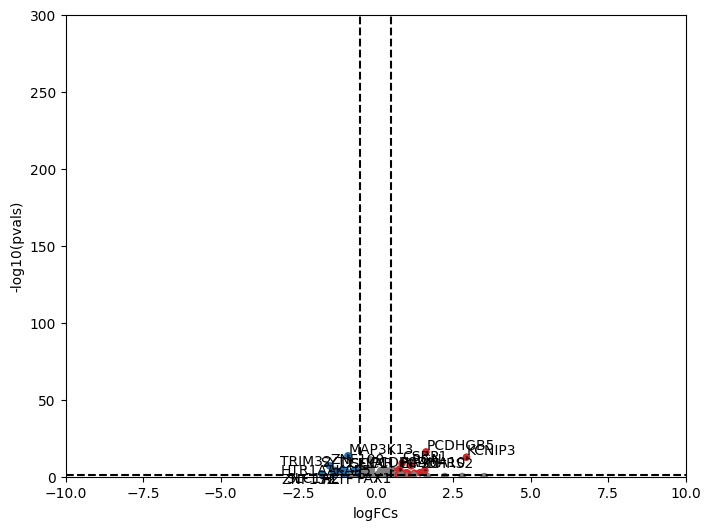

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    ax=ax
)
ax.set_xlim(-10, 10)
ax.set_ylim(0, 300)
plt.savefig('../figures/WT/t0_volcano.png')

In [21]:
mat = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
mat

gene_name,CHGA,MT-CO1,GCG,INS,MT-ND4,EEF1A1,MT-ND5,TTR,MT-CO2,MT-CYB,...,AC104131.1,USP6,GBP3,AL353597.3,AC005828.4,GRM7,PTPRD-AS2,AL353597.1,AC107918.4,AL354811.1
treatment.vs.control,0.860242,1.502934,0.793825,2.096183,1.325099,1.601961,1.453667,2.721134,1.185724,1.648211,...,-0.090166,-0.18603,-0.685767,-0.307872,-0.164703,0.549854,-0.557991,-0.021062,-0.51896,-0.40718


### Transcription factor activity inference

In [37]:
collectri = dc.get_collectri(organism='human')
collectri.to_csv('colllectri.csv', index=False)
collectri

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


### Activity inference with Univariate Linear Model (ULM)

In [23]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 15760 targets for 651 sources.


,ABL1,AHR,AHRR,AIP,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,...,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91
treatment.vs.control,-0.895203,-0.460967,1.406103,0.542412,-0.716238,-0.821773,-0.550384,-1.658729,-0.358155,-3.103555,...,-2.279041,-0.353638,1.823362,0.276505,-1.735698,-0.070876,0.822748,0.504119,-1.825189,1.671354


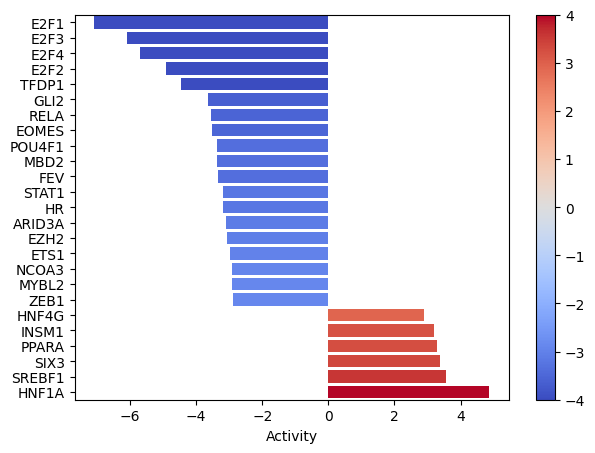

In [24]:
dc.plot_barplot(
    tf_acts,
    'treatment.vs.control',
    top=25,
    vertical=True,
    vmin=4,
    vmax=4,
    save='../figures/WT/t0_tf_activities.png'
)

In [25]:
#activated
# dc.plot_targets(results_df, stat='stat', source_name='HNF1A', net=collectri, top=15,save='../figures/WT/t0_HNF1A_targets.png')
# dc.plot_targets(results_df, stat='stat', source_name='SIX3', net=collectri, top=15,save='../figures/WT/t0_SiX3_targets.png')
# dc.plot_targets(results_df, stat='stat', source_name='SREBF1', net=collectri, top=15,save='../figures/WT/t0_SREBF1_targets.png')
# dc.plot_targets(results_df, stat='stat', source_name='PPARA', net=collectri, top=15,save='../figures/WT/t0_PPARA_targets.png')
# dc.plot_targets(results_df, stat='stat', source_name='MTF1', net=collectri, top=15,save='../figures/WT/t0_MTF1_targets.png')
# dc.plot_targets(results_df, stat='stat', source_name='INSM1', net=collectri, top=15,save='../figures/WT/t0_INSM1_targets.png')
# dc.plot_targets(results_df, stat='stat', source_name='NACC1', net=collectri, top=15,save='../figures/WT/t0_NACC1_targets.png')
# #inhibited
# dc.plot_targets(results_df, stat='stat', source_name='E2F1', net=collectri, top=15,save='../figures/WT/t0_E2F1_targets.png')
# #MAFA
# dc.plot_targets(results_df, stat='stat', source_name='MAFA', net=collectri, top=15,save='../figures/WT/t0_MAFA_targets.png')

## Plot Network

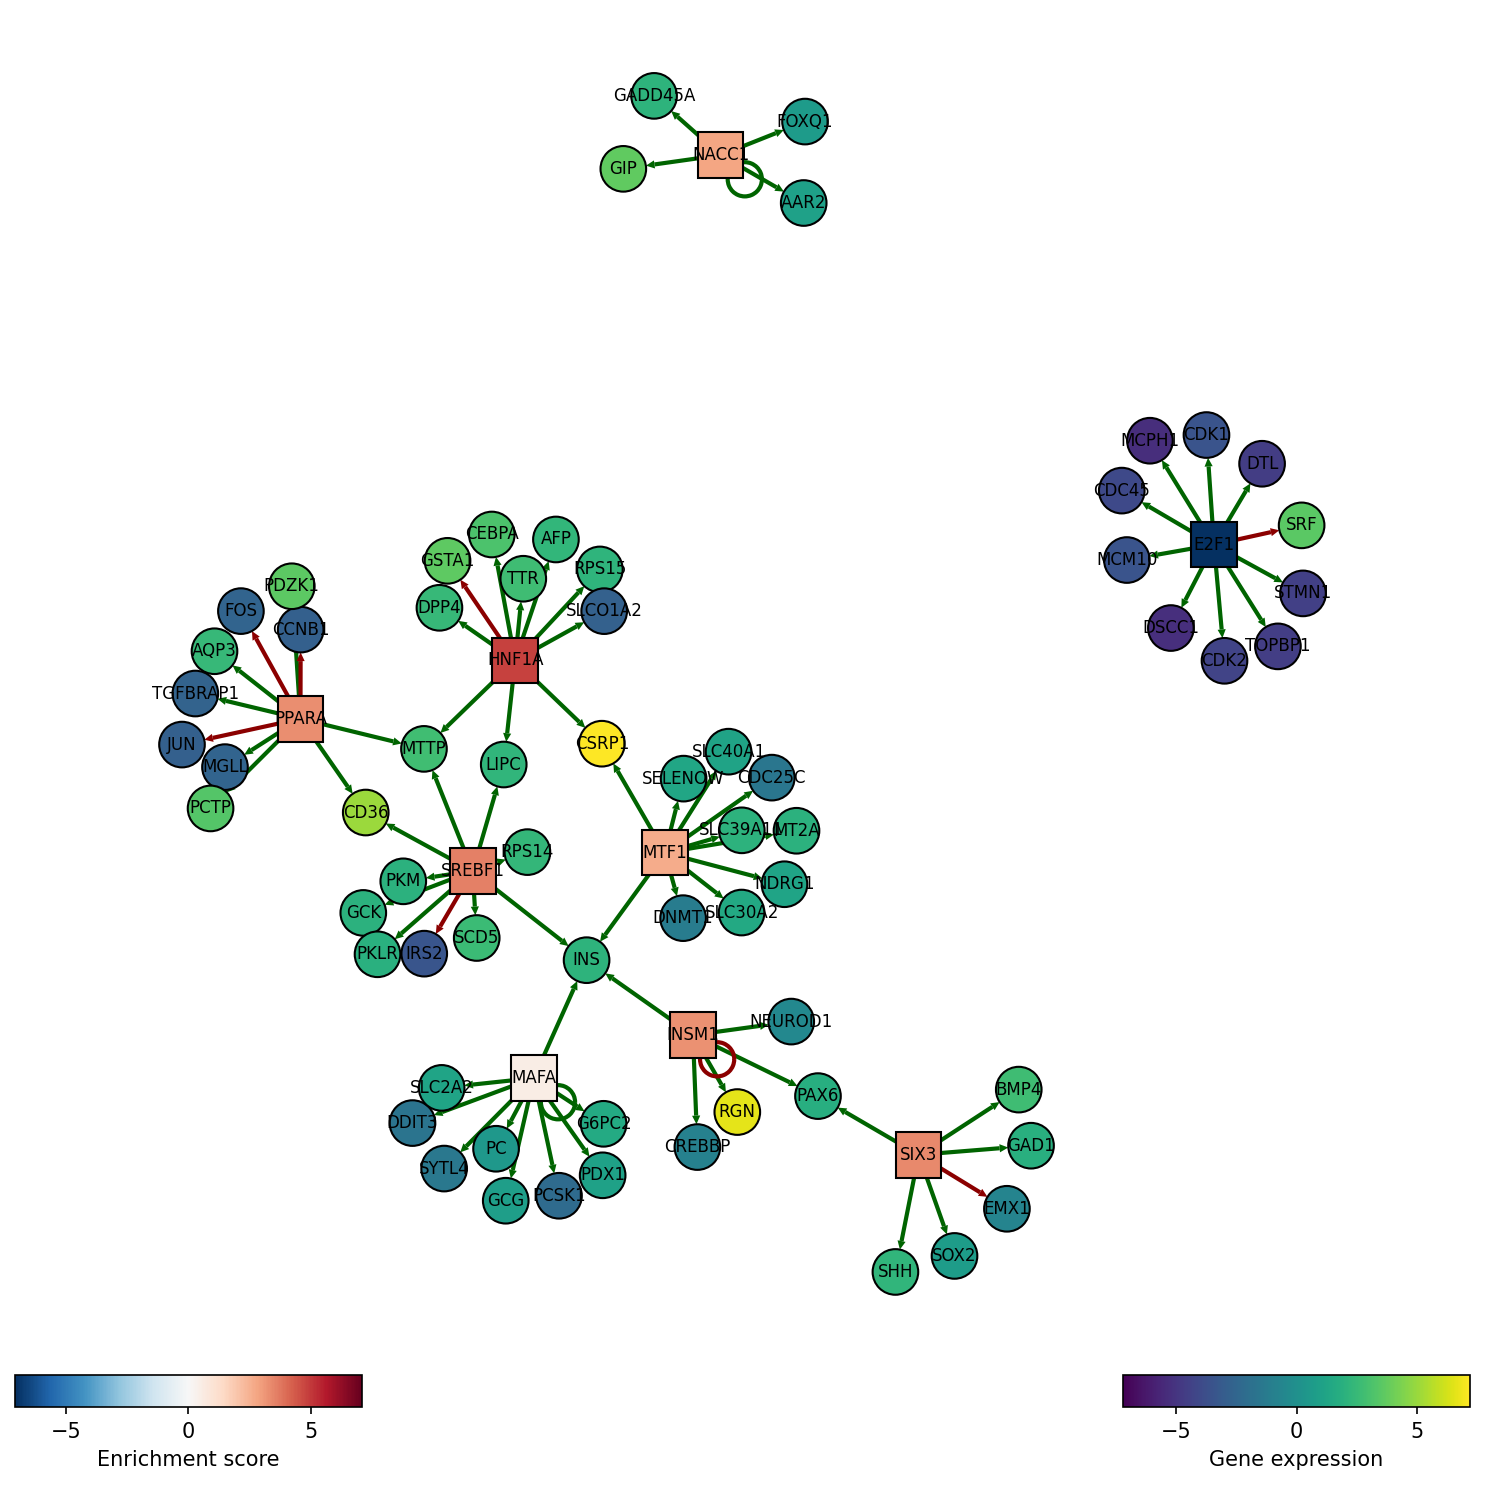

In [26]:
dc.plot_network(
    net=collectri,
    obs=mat,
    act=tf_acts,
    n_sources=['HNF1A', 'SIX3', 'SREBF1', 'PPARA', 'MTF1', 'INSM1', 'NACC1', 'E2F1', 'MAFA'],
    #n_sources=['HNF1A', 'SIX3', 'SREBF1', 'E2F1'],
    n_targets=10,
    node_size=0.5,
    label_size=8,
    figsize=(10, 10),
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    vcenter=True,
    save = '../figures/WT/t0_plot_networks.png'
)

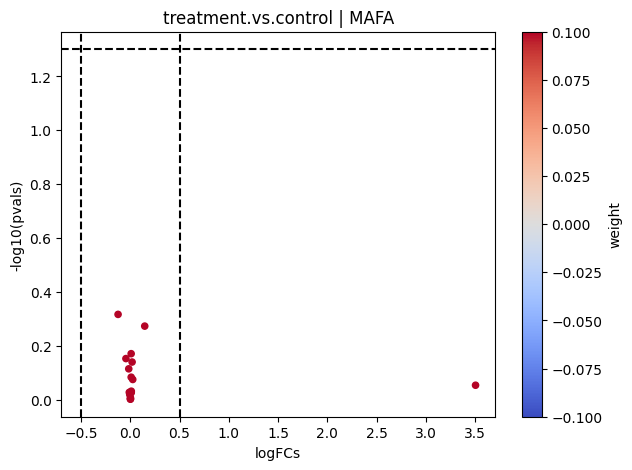

In [27]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'treatment.vs.control'})
pvals = results_df[['padj']].T.rename(index={'padj': 'treatment.vs.control'})

# Plot
dc.plot_volcano(logFCs, pvals, 'treatment.vs.control', name='MAFA', net=collectri, top=10, sign_thr=0.05, lFCs_thr=0.5)

### Pathway activity inference

In [28]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,1.522388e-06
6996,p53,CFDP1,-1.628168,1.526045e-06
6997,p53,VPS37D,2.309503,1.537098e-06
6998,p53,TEDC1,-2.274823,1.547037e-06


### Activity inference with multivariate Linear Model (MLM)

In [29]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True)
pathway_acts

Running mlm on mat with 1 samples and 15760 targets for 14 sources.


,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
treatment.vs.control,1.396701,2.235157,0.006786,-0.735686,-6.577917,-3.838701,-0.876119,-4.925832,-0.247484,0.920301,-0.109097,0.071337,0.748723,5.478592


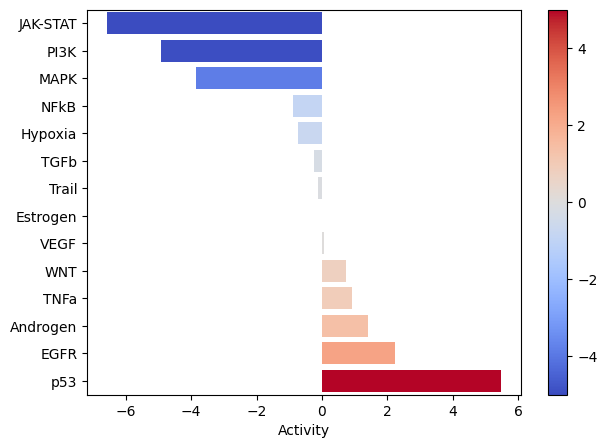

In [30]:
dc.plot_barplot(
    pathway_acts,
    'treatment.vs.control',
    top=25,
    vertical=True,
    vmin=-5,
    vmax=5,
    save='../figures/WT/t0_pathway_activities.png'
)

In [31]:
# increase activity
# dc.plot_targets(results_df, stat='stat', source_name='p53', net=progeny, top=30,save='../figures/WT/t0_p53_targets.png')
# dc.plot_targets(results_df, stat='stat', source_name='EGFR', net=progeny, top=30, save='../figures/WT/t0_EGFR_targets.png')
# dc.plot_targets(results_df, stat='stat', source_name='Androgen', net=progeny, top=30,save='../figures/WT/t0_Androgen_targets.png')
# # decrease activity
# dc.plot_targets(results_df, stat='stat', source_name='JAK-STAT', net=progeny, top=30, save='../figures/WT/t0_JAK-STAT_targets.png')

# Approach to investigate p53 -> PPI -> mechanism? -> ask -> Table with list of targets for each one of the pathways with statistics 

### Funtional enrichment of Biological Terms

In [32]:
# The Molecular Signatures Database (MSigDB) is a resource containing a collection of gene sets annotated to different biological processes.
# msigdb = dc.get_resource('MSigDB')
# msigdb

In [33]:
# msigdb['collection'].unique()

In [34]:
# # Filter by hallmark
# msigdb = msigdb[msigdb['collection']=='hallmark']

# # Remove duplicated entries
# msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# # Rename
# msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

# msigdb

## ORA

In [35]:
# # Infer enrichment with ora using significant deg
# top_genes = results_df[results_df['padj'] < 0.05]

# # Run ora
# enr_pvals = dc.get_ora_df(
#     df=top_genes,
#     net=msigdb,
#     source='geneset',
#     target='genesymbol'
# )

# enr_pvals.head()

In [36]:
# dc.plot_dotplot(
#     enr_pvals.sort_values('Combined score', ascending=False).head(15),
#     x='Combined score',
#     y='Term',
#     s='Odds ratio',
#     c='FDR p-value',
#     scale=0.4,
#     figsize=(5, 10),
#     save='../figures/WT/t0_ORA.png'
# )